# Assignment 4 - DDPG

During labs you have learnt about DQN - an algorithm for solving discrete action environments.
In this task you will implement DDPG which can be thought of as DQN variation for environments with continuous action space.

You should implement missing parts of the training loop which are annotated with the following comment:
```
#########################
### TODO - YOUR CODE ####
#########################
```



Here is the pesudocode from the original work: 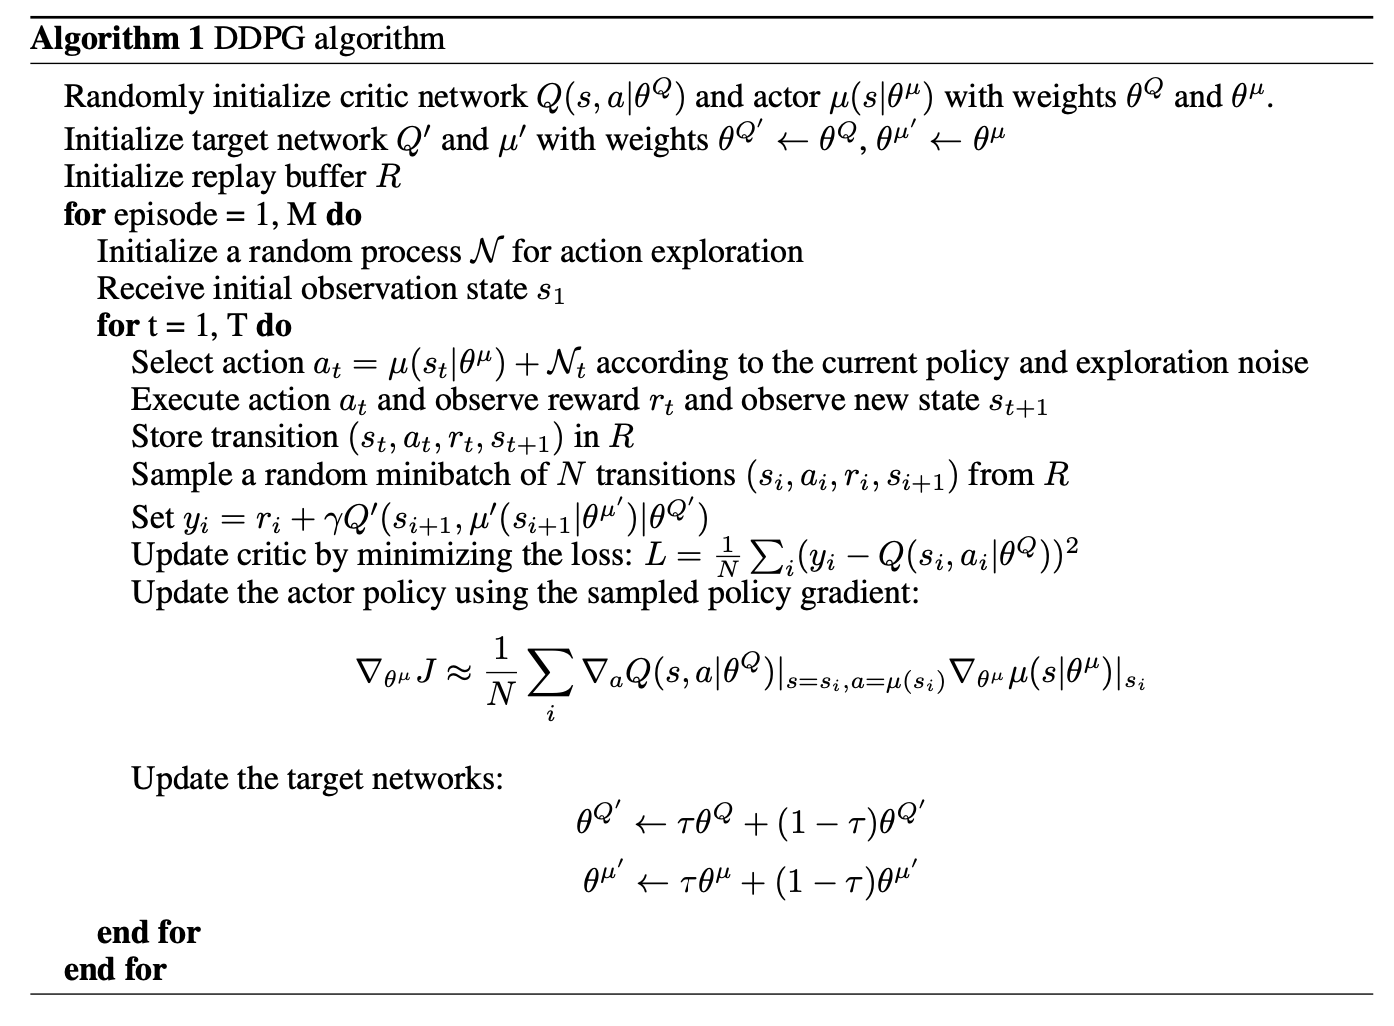

### Resources

- [openai/gym](https://gym.openai.com/docs/)
- [getting-started-with-openai-gym](https://blog.paperspace.com/getting-started-with-openai-gym/)
- [Continuous control with deep reinforcement learning (DDPG)](https://arxiv.org/abs/1509.02971)
- [Deterministic Policy Gradient Algorithms](http://proceedings.mlr.press/v32/silver14.pdf)

You can read about actor policy update step and how to implement it here:
- https://www.quora.com/Why-is-the-loss-for-DDPG-Actor-the-product-of-gradients-of-Q-values-actions
- https://stackoverflow.com/questions/51496159/ddpg-deep-deterministic-policy-gradients-how-is-the-actor-updated


## Requirements

1. Experiments reproducability:

    You should ensure that you can re-run your experiments and obtain the same results. To do so implement `set_seed` function that handles necessary logic. Pick one of the experiments (short one) and re-run it with logging of the losses/mean_rewards to show that results are reproduced.

2. Implement Polyak average for updating network's parameters:

    During labs about DQN you have seen that target's network parameters can be updated every K steps by overwritting old parameters. There are other, more robust, methods to do so. One of the most popular is polyak average (weighted moving average). Your tasks will be to implement it as well.

3. Implement DDPG algorithm:

    Read paper carefully, and don't forget about exploration.

4. Environments:

    Solve the environmets listed below and reach the corresponding benchmark score.

5. Analysis of different hyperparameters.

    Pick one of the environments and repeat the training 5 times with a different subset of hyperparameters such that the results differ. Present comparison of used parameters' configurations, training summary, plots, and your conclusions.

    Tip: RL algorithms are especially parameter sensitive. It's a good occasion to ponder how to organize your work such that you can easily track and compare different runs and configurations. Organize your experiments or use a utility such as [tensorboard](https://pytorch.org/docs/stable/tensorboard.html), [neptune](neptune.ai), [wandb](wandb.ai) or [clearml](https://clear.ml/).


### Evaluation & Grading

Total points: 12
- Seed initalization & experiment reproducibility [0.5]
- Polyak average [0.5]
- Gaussian noise [0.5]
- DDPG [5.5]
- Solving environments (benchmark) [3.0]
- Analysis of different hyperparameters [2.0]

#### Benchmark
For each of the following environments you should train one agent and obtain at least the following mean score in our benchmark:
```
"Pendulum-v1" : -160,
"LunarLanderContinuous-v2": 130,
"MountainCarContinuous-v0": 80
```



Tips:
- Study environment's action space and ensure that your cover the whole range. Perhaps Tanh activation could be useful?
- Adding noise to the action can take you out of the environment's action space. Ensure that the final action is valid before calling `env.step(action)`.
- RL agents tend to forget previously learnt behaviors, especially if algorithm is not very stable. Therefore, it's a good practice to evaluate and save checkpoints (weights of the model) every K-th steps. You can later load the best set of parameters.
- Here are a few statistics that are usefull to track your training progress:
```
logs = {
    "episodes_rews": [],
    "episodes_lens": [],
    "critic_losses": [], 
    "actor_losses": []
}
```
For example, it's useful to log mean episode reward for last 50 episodes.

# Environment setup, helper functions & classes

Remember to restart your runtime after installing the packages.

In [1]:
import copy
import os
import random

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from clearml import Task
from torch import device
from typing import List, Optional, Callable, Tuple
from collections import namedtuple, deque
import imageio
from pathlib import Path
import gym
from pyvirtualdisplay import Display
import matplotlib.pyplot as plt

In [2]:
web_server = 'https://app.community.clear.ml'
api_server = 'https://api.community.clear.ml'
files_server = 'https://files.community.clear.ml'
access_key = ''#@param {type:"string"}
secret_key = ''#@param {type:"string"}

Task.set_credentials(web_host=web_server,
                     api_host=api_server,
                     files_host=files_server,
                     key=access_key,
                     secret=secret_key)

### Benchmark

Don't modify Benchmark's cell. Your solution should pass the proposed thresholds.

In [3]:
def as_tensor(data: np.ndarray, dtype=torch.float32, batch: bool = False) -> torch.Tensor:
    tensor = torch.tensor(data, dtype=dtype, device=DEVICE)
    if batch and len(tensor.shape) == 1:
        tensor = tensor.unsqueeze(dim=1)
    return tensor

class Benchmark:
    def __init__(self):
        """ Don't modify. Your agent should pass those benchmarks. """
        self.env_to_mean_score = {
            "Pendulum-v1" : -160,
            "LunarLanderContinuous-v2": 130,
            "MountainCarContinuous-v0": 80
        }
        self.n_episodes = 100
        self.seed = 42
    
    def run(self, env_id: str, policy) -> None:
        env = gym.make(env_id)
        stats = self._eval(env, policy, self.n_episodes, self.seed)
        score = np.mean(stats["episodes_rews"])
        result = "Success" if score > self.env_to_mean_score[env_id] else "Failure"
        print(f"{result} on {env_id} with mean score: {score}")
        assert len(stats["episodes_rews"]) == self.n_episodes

    def _eval(self, env, policy, n_episodes: int = 100, seed: Optional[int] = None):
        print("\nStarting Benchmark:")
        print("seed:", seed)
        print("n_episodes:", n_episodes)
        if seed: # Be careful, this will reset your rng!
            set_seeds(env, seed)

        stats = {
            "episodes_rews": [],
            "episodes_lens": [],
        }
        
        for episode in range(n_episodes):
            done = False
            obs = env.reset()
            ep_rew, ep_len = 0, 0

            while not done:
                with torch.no_grad():
                    action = policy(as_tensor(obs)).numpy() # No exploration noise during evaluation!
                obs, reward, done, _ = env.step(action)
                ep_rew += reward
                ep_len += 1
            
            stats["episodes_lens"].append(ep_len)
            stats["episodes_rews"].append(ep_rew)

        print("Rewards:", stats["episodes_rews"])
        print("Lengths:", stats["episodes_lens"])
        print("Mean episode reward:", np.mean(stats["episodes_rews"]))
        print("Mean episode length:", np.mean(stats["episodes_lens"]))

        return stats

### Utilities

A few helper functions to help you get started.

In [4]:
def eval(env, policy, n_episodes: int = 100, seed: Optional[int] = None):
    """ Helper method to evaluate agent """
    if seed: # Be careful, this will reset your rng!
        set_seeds(env, seed)

    stats = {
        "episodes_rews": [],
        "episodes_lens": [],
    }
    
    for episode in range(n_episodes):
        done = False
        obs = env.reset()
        ep_rew, ep_len = 0, 0

        while not done:
            with torch.no_grad():
                action = policy(as_tensor(obs)).numpy() # No exploration noise during evaluation
            obs, reward, done, _ = env.step(action)
            ep_rew += reward
            ep_len += 1
        
        stats["episodes_lens"].append(ep_len)
        stats["episodes_rews"].append(ep_rew)

    #print("Rewards:", stats["episodes_rews"])
    #print("Lengths:", stats["episodes_lens"])
    print("Mean episode reward:", np.mean(stats["episodes_rews"]))
    print("Mean episode length:", np.mean(stats["episodes_lens"]))

    return stats

def benchmark(policy, seed, env_id):
    benchmark = Benchmark()
    benchmark.seed = seed
    policy.eval()
    benchmark.run(env_id, policy)

def make_gif(env_id, actor = None, n_episodes: int = 1, gif_name: str = "agent.gif", dir: str = "./gifs"):
    """
    Create a gif of an agent interacting with an environment.
    Note: It does not always work in Google colab, and crashes from time to time.
    """
    display = Display(visible=0, size=(1400, 900))
    display.start()

    Path(dir).mkdir(parents=True, exist_ok=True)
    filename = Path(dir).joinpath(gif_name)

    images = []
    env = gym.make(env_id)
    for _ in range(n_episodes):
        obs, done = env.reset(), False
        images.append(env.render("rgb_array"))
        while not done:
            if actor:
                with torch.no_grad():
                    action = actor(as_tensor(obs)).numpy()
            else:
                action = env.action_space.sample()
            obs, reward, done, _ = env.step(action)
            images.append(env.render("rgb_array"))

    imageio.mimsave(filename, images, fps=29)

def try_gpu(i: int = 0) -> device:
    """ Return gpu(i) if exists, otherwise return cpu() """
    #if torch.cuda.device_count() >= i + 1:
    #    return torch.device(f'cuda:{i}')
    return torch.device('cpu')

In gym environments Box(n,) corresponds to the n-dimensional continuous space. The observation space has upper and lower bounds that describe the range of values it can take.

In [5]:
def describe_env(env_id: str) -> None:
    env = gym.make(env_id)
    spec = gym.spec(env_id)
    print(f"Environment: {env_id}")
    print(f"Observation Space: {env.observation_space}")
    print(f"Observation Space High: {env.observation_space.high}")
    print(f"Observation Space Low: {env.observation_space.low}")
    print(f"Action Space: {env.action_space}")
    print(f"Max Episode Steps: {spec.max_episode_steps}")
    print(f"Nondeterministic: {spec.nondeterministic}")
    print(f"Reward Range: {env.reward_range}")
    print(f"Reward Threshold: {spec.reward_threshold}")

continuous_envs = ["Pendulum-v1", "LunarLanderContinuous-v2", "MountainCarContinuous-v0"]

print(80*"#" + "\n")
for i, env in enumerate(continuous_envs):
    describe_env(env)
    print("\n" + 80*"#" + "\n")

################################################################################

Environment: Pendulum-v1
Observation Space: Box([-1. -1. -8.], [1. 1. 8.], (3,), float32)
Observation Space High: [1. 1. 8.]
Observation Space Low: [-1. -1. -8.]
Action Space: Box([-2.], [2.], (1,), float32)
Max Episode Steps: 200
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: None

################################################################################

Environment: LunarLanderContinuous-v2
Observation Space: Box([-inf -inf -inf -inf -inf -inf -inf -inf], [inf inf inf inf inf inf inf inf], (8,), float32)
Observation Space High: [inf inf inf inf inf inf inf inf]
Observation Space Low: [-inf -inf -inf -inf -inf -inf -inf -inf]
Action Space: Box([-1. -1.], [1. 1.], (2,), float32)
Max Episode Steps: 1000
Nondeterministic: False
Reward Range: (-inf, inf)
Reward Threshold: 200

################################################################################

Environment: MountainC

In [6]:
# is_terminal is a mask indicating whether the state is terminal or not
# it is useful when using target_net for predicting qvalues.
Transition = namedtuple("Transition",
                        ("state", "action", "next_state", "reward", "is_terminal"))

class ReplayBuffer(object):
    def __init__(self, size: int):
        """ Create new replay buffer. """
        self._storage = deque(maxlen=size)
        self._capacity = size

    def add(self, transition: Transition) -> None:
        self._storage.append(transition)

    def sample(self, batch_size: int) -> List[Transition]:
        """ Sample batch of experience from memory. """
        batch = random.sample(self._storage, batch_size)
        return batch

    def __len__(self) -> int:
        return len(self._storage)

class GaussianNoise:
    """
    Returns function that samples noise of shape action_dim from the normal distribution N(mean, std)
    """
    def __init__(self, action_space, mean: float, std: float):
        self.action_dim = action_space.shape[0]
        self.low = action_space.low
        self.high = action_space.high
        self.mean = mean
        self.std = std

    def __call__(self, action):
        noise = np.random.normal(self.mean, self.std, self.action_dim)
        return np.clip(action + noise, self.low, self.high)

In [7]:
class MLP(nn.Module):
    """ Simple MLP net.

    Each of the layers, despite the last one, is followed by `activation`, and the last one
    is optionally followed by `output_activation`.
    """
    def __init__(self, layers_sizes: List[int], output_activation: Optional[nn.Module] = None) -> None:
        super(MLP, self).__init__()

        modules = []
        for in_features, out_features in zip(layers_sizes, layers_sizes[1:-1]):
            modules.extend([
                nn.Linear(in_features, out_features),
                nn.ReLU()
            ])
        modules.extend([nn.Linear(layers_sizes[-2], layers_sizes[-1])])
        if output_activation:
            modules.extend([output_activation()])
        self.layers = nn.Sequential(*modules)

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        return self.layers(obs)

    def save(self, path: str) -> None:
        torch.save(self.state_dict(), path)

    def load(self, path: str) -> None:
        self.load_state_dict(torch.load(path))

class Actor(MLP):
    def __init__(self, action_scale: float, *args, **kwargs):
        """
        Sometimes environment's have action range bigger than (-1, 1).
        Thus we want to scale it appropriately to cover the whole range. Here we assume that the
        final layer is Tanh so scaling the output is enough.
        """
        super(Actor, self).__init__(*args, **kwargs)
        self.action_scale = action_scale

    def forward(self, obs: torch.Tensor) -> torch.Tensor:
        return self.action_scale * super().forward(obs)

class Critic(MLP):
    def __init__(self, *args, **kwargs):
        super(Critic, self).__init__(*args, **kwargs)

    def forward(self, obs: torch.Tensor, action: torch.Tensor) -> torch.Tensor:
        return super().forward(torch.cat([obs, action], 1))

# Solution

## Code

In [8]:
def set_seeds(env: gym.Env, seed=42) -> None:
    """
    Set random seeds for reproducibility.
    See: https://pytorch.org/docs/stable/notes/randomness.html
         https://harald.co/2019/07/30/reproducibility-issues-using-openai-gym/
    """
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    env.seed(seed)
    env.action_space.seed(seed)

def polyak_average(net1: nn.Module, net2: nn.Module, tau: float) -> None:
    """
    Update parameters of net1 with parameters of net2 as a weighted sum of both.
    """
    for param1, param2 in zip(net1.parameters(), net2.parameters()):
        param1.data.copy_(tau * param1.data + (1.0 - tau) * param2.data)

def test_polyak_average():
    net1, net2 = MLP([2, 2]), MLP([2, 2])
    with torch.no_grad():
        net1.layers[0].weight.fill_(1)
        net1.layers[0].bias.fill_(1)
        net2.layers[0].weight.fill_(-1)
        net2.layers[0].bias.fill_(0.5)
    print(list(net1.named_parameters()))
    print(list(net2.named_parameters()))
    polyak_average(net1, net2, tau=0.9)
    print(list(net1.named_parameters()))

    expected_weight = torch.tensor([[0.8, 0.8], [0.8, 0.8]])
    expected_bias = torch.tensor([0.95, 0.95])
    assert torch.allclose(net1.layers[0].weight.data, expected_weight)
    assert torch.allclose(net1.layers[0].bias.data, expected_bias)

test_polyak_average()

[('layers.0.weight', Parameter containing:
tensor([[1., 1.],
        [1., 1.]], requires_grad=True)), ('layers.0.bias', Parameter containing:
tensor([1., 1.], requires_grad=True))]
[('layers.0.weight', Parameter containing:
tensor([[-1., -1.],
        [-1., -1.]], requires_grad=True)), ('layers.0.bias', Parameter containing:
tensor([0.5000, 0.5000], requires_grad=True))]
[('layers.0.weight', Parameter containing:
tensor([[0.8000, 0.8000],
        [0.8000, 0.8000]], requires_grad=True)), ('layers.0.bias', Parameter containing:
tensor([0.9500, 0.9500], requires_grad=True))]


In [9]:
class DDPGAgent:
    def __init__(self,  config, load_model=False):
        self.env_id = config['env_id']
        self.seed = config['seed']
        self.env = gym.make(self.env_id)
        set_seeds(self.env, self.seed)
        self.noise = GaussianNoise(self.env.action_space, config['noise_mean'], config['noise_std'])

        num_states = self.env.observation_space.shape[0]
        num_actions = self.env.action_space.shape[0]

        # Params
        self.total_steps = 0
        self.batch_size = config['batch_size']
        self.max_episode_steps = config['max_episode_steps']
        self.exploration_steps = config['exploration_steps']
        self.action_scale = self.env.action_space.high[0].item()
        self.gamma = config['gamma']
        self.tau = config['tau']

        # Networks
        self.actor = Actor(self.action_scale, layers_sizes=[num_states, 32, 32, num_actions], output_activation=nn.Tanh).to(DEVICE)
        if load_model:
            self.actor.load(os.path.realpath(f'./models/{config["env_id"]}.pt'))
        self.critic = Critic(layers_sizes=[num_states + num_actions, 64, 64, 1]).to(DEVICE)
        self.actor_target = copy.deepcopy(self.actor)
        self.critic_target = copy.deepcopy(self.critic)

        # Training
        self.replay_buffer = ReplayBuffer(config['buffer_size'])
        self.actor_optim = torch.optim.Adam(self.actor.parameters(), lr=config['actor_lr'])
        self.critic_optim = torch.optim.Adam(self.critic.parameters(), lr=config['critic_lr'])

    def logging(self, logger, episode, episode_reward, steps, act_loss, crit_loss):
        logger.report_scalar('episodes_rews', 'episodes_rews', iteration=episode, value=episode_reward)
        logger.report_scalar('episodes_lens', 'episodes_lens', iteration=episode, value=steps)
        logger.report_scalar('actor_losses', 'actor_losses', iteration=episode, value=act_loss)
        logger.report_scalar('critic_losses', 'critic_losses', iteration=episode, value=crit_loss)

        print(f'Episode {episode}: reward = {episode_reward} | steps = {steps} | actor loss = {act_loss} | critic loss = {crit_loss}')

    def get_action(self, obs):
        """
        At the beginning explore randomly before using policy. This helps with exploration.
        Then calculate next action with exploration via Gaussian noise. Remember to:
        1. Not calculate gradients for this forward pass.
        2. Include exploration noise.
        3. Clip action to fit within the environment's action space after adding the noise.
        """
        if self.total_steps < self.exploration_steps:
            action = self.env.action_space.sample()
        else:
            obs = as_tensor(obs)
            with torch.no_grad():
                action = self.actor(obs).cpu().numpy()
                action = self.noise(action)

        return action

    def critic_loss(self, batch):
        """ Calculate critic's loss for a given batch. """
        with torch.no_grad():
            next_action = self.actor_target(batch.next_state)
            q_target_next = self.critic_target(batch.next_state, next_action.detach())
        q_target = batch.reward + self.gamma * q_target_next * (1 - batch.is_terminal)
        q_value = self.critic(batch.state, batch.action)
        return F.mse_loss(q_value, q_target)

    def actor_loss(self, batch):
        """
        Calculate actor's loss for a given batch.
        Remember that we want to maximize qvalue returned by critic, which represents the expected
        future reward. Therefore, we want to do gradient ascent. However, optimizer always performs
        gradient descent.
        """
        action = self.actor(batch.state)
        with torch.no_grad():
            loss = self.critic(batch.state, action)
        return -loss.mean()

    def update_step(self):
        # Sample minibatch
        transitions = self.replay_buffer.sample(self.batch_size)
        # Convert from list of tuples to tuple of lists
        batch = Transition(*zip(*transitions))
        batch = Transition(as_tensor(batch.state, batch=True),
                           as_tensor(batch.action, batch=True),
                           as_tensor(batch.next_state, batch=True),
                           as_tensor(batch.reward, batch=True),
                           as_tensor(batch.is_terminal, batch=True))

        # Critic step ~ 4/5 lines
        self.critic_optim.zero_grad()
        crit_loss = self.critic_loss(batch)
        crit_loss.backward()
        self.critic_optim.step()

        # Actor step ~ 4/5lines
        self.actor_optim.zero_grad()
        act_loss = self.actor_loss(batch)
        act_loss.backward()
        self.actor_optim.step()

        # Update target networks ~ 2 lines
        polyak_average(self.actor_target, self.actor, self.tau)
        polyak_average(self.critic_target, self.critic, self.tau)

        return act_loss.item(), crit_loss.item()

    def play_episode(self):
        steps = 0
        episode_reward = 0
        episode_actor_loss = 0
        episode_critic_loss = 0
        obs = self.env.reset()
        for step in range(self.max_episode_steps):
            self.total_steps += 1
            action = self.get_action(obs)

            # Interaction with the environment, updates, logs.
            new_obs, reward, is_terminal, _ = self.env.step(action)
            transition = Transition(obs, action, new_obs, reward, is_terminal)
            self.replay_buffer.add(transition)
            if self.total_steps > self.batch_size:
                act_loss, crit_loss = self.update_step()
                episode_actor_loss += act_loss
                episode_critic_loss += crit_loss

            obs = new_obs
            steps = step
            episode_reward += reward

            if is_terminal:
                break

        return episode_reward, steps+1, (episode_actor_loss / steps), (episode_critic_loss / steps)

    def train(self, config):
        prev_rewards = -1000
        task = Task.init(project_name='Homework_4', task_name=config['env_id'], reuse_last_task_id=False, continue_last_task=False)
        task.connect(config)
        logger = task.get_logger().current_logger()
        self.actor.train()
        self.critic.train()
        self.actor_target.eval()
        self.critic_target.eval()
        for episode in range(config['episodes']):
            episode_reward, steps, act_loss, crit_loss = self.play_episode()
            self.logging(logger, episode, episode_reward, steps, act_loss, crit_loss)
            if episode_reward > prev_rewards:
                ddpg_agent.actor.save(os.path.join(f'./models/{config["env_id"]}.pt'))

        task.mark_completed()
        task.close()

        return task

    def eval(self):
        self.actor.eval()
        eval(self.env, self.actor, n_episodes=10)
        self.actor.train()

In [15]:
config = {
    'env_id': 'Pendulum-v1',
    'buffer_size': 20000,
    'batch_size': 128,
    'exploration_steps': 0,
    'episodes': 40,
    'max_episode_steps': 500,
    'actor_lr': 1e-3,
    'critic_lr': 1e-2,
    'tau': 0.99,
    'gamma': 0.99,
    'noise_mean': 0.0,
    'noise_std': 0.3,
    'seed': 3275301815
}

# config = {
#     'env_id': 'LunarLanderContinuous-v2',
#     'buffer_size': 1000000,
#     'batch_size': 64,
#     'exploration_steps': 1000,
#     'episodes': 195,
#     'max_episode_steps': 1000,
#     'actor_lr': 1e-3,
#     'critic_lr': 1e-2,
#     'tau': 0.99,
#     'gamma': 0.99,
#     'noise_mean': 0.0,
#     'noise_std': 0.3,
#     'seed': 1119513121
# }

# config = {
#     'env_id': 'MountainCarContinuous-v0',
#     'buffer_size': 1000000,
#     'batch_size': 64,
#     'exploration_steps': 10000,
#     'episodes': 100,
#     'max_episode_steps': 1000,
#     'actor_lr': 1e-4,
#     'critic_lr': 1e-3,
#     'tau': 0.999,
#     'gamma': 0.99,
#     'noise_mean': 0.0,
#     'noise_std': 1,
#     'seed': 623638129
# }

DEVICE = try_gpu()

ddpg_agent = DDPGAgent(config, load_model=True)
ddpg_agent.train(config)
benchmark(ddpg_agent.actor, ddpg_agent.seed, ddpg_agent.env_id)

ClearML Task: created new task id=338b4d974461478cbe8c7abea48c2823
ClearML results page: https://app.community.clear.ml/projects/c1f8b76d530d422893e750c269ba680c/experiments/338b4d974461478cbe8c7abea48c2823/output/log
Episode 0: reward = -313.99150133803914 | steps = 82 | actor loss = 0.47690977027386794 | critic loss = 2.5452114667421504
Episode 1: reward = -59.70279381444553 | steps = 128 | actor loss = 2.2729836570934987 | critic loss = 21.55824298276676
Episode 2: reward = -190.5722701006887 | steps = 107 | actor loss = 0.5739930971824335 | critic loss = 10.674106649632725
Episode 3: reward = -232.40449487589638 | steps = 82 | actor loss = 1.858401152546759 | critic loss = 23.47860190971398
Episode 4: reward = -87.86803893165815 | steps = 109 | actor loss = 1.7950354039117142 | critic loss = 21.444549104681723
Episode 5: reward = -247.71710533837486 | steps = 116 | actor loss = 0.34285142978896266 | critic loss = 26.08689587323562
Episode 6: reward = -334.54943370844876 | steps = 9

In [10]:
# Experiments reproducibility
DEVICE = try_gpu()
config = {
    'env_id': 'Pendulum-v1',
    'buffer_size': 20000,
    'batch_size': 128,
    'exploration_steps': 0,
    'episodes': 20,
    'max_episode_steps': 500,
    'actor_lr': 1e-3,
    'critic_lr': 1e-2,
    'tau': 0.99,
    'gamma': 0.99,
    'noise_mean': 0.0,
    'noise_std': 0.3,
    'seed': 3275301815
}

ddpg_agent = DDPGAgent(config)
ddpg_agent.train(config)
ddpg_agent = DDPGAgent(config)
ddpg_agent.train(config)

ClearML Task: created new task id=f94c3c451f1c448fb909f3ae38a5fe74
ClearML new version available: upgrade to v1.1.6 is recommended!
ClearML results page: https://app.community.clear.ml/projects/c1f8b76d530d422893e750c269ba680c/experiments/f94c3c451f1c448fb909f3ae38a5fe74/output/log


/tmp/ipykernel_63243/2040442887.py:2: UserWarning:

Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:201.)



Episode 0: reward = -1251.8234065127863 | steps = 200 | actor loss = 2.469628313827754 | critic loss = 1.8587155039586014
Episode 1: reward = -1767.5641349817574 | steps = 200 | actor loss = 14.447453748041662 | critic loss = 0.3639388209087166
Episode 2: reward = -1372.783922039146 | steps = 200 | actor loss = 25.908644911032827 | critic loss = 1.7782212000471265
Episode 3: reward = -1207.6107706543976 | steps = 200 | actor loss = 37.35712185576933 | critic loss = 4.7274942651915195
Episode 4: reward = -1493.1444248497546 | steps = 200 | actor loss = 49.012532814064215 | critic loss = 10.851145767836115
Episode 5: reward = -1124.3943995587897 | steps = 200 | actor loss = 59.69403486395601 | critic loss = 15.85200508006254
Episode 6: reward = -979.7203142230594 | steps = 200 | actor loss = 68.11124485341747 | critic loss = 22.104876363097723
2022-02-06 23:42:43,740 - clearml.frameworks - INFO - Found existing registered model id=0837f4b321994e298c3db5d3c66db8f2 [/home/michal/Dokumenty/

In [16]:
task_ids = ['2919676aec1c48fb895890a979321ec3', '338b4d974461478cbe8c7abea48c2823', 'd03d477c6e04468ab84514973d45f263']

def benchmark_all(task_ids: List):
    for task_id in task_ids:
        task = Task.get_task(task_id)
        config = task.get_parameters()
        config = {k.replace('General/', ''): v for k, v in config.items()}
        env = gym.make(config['env_id'])
        num_states = env.observation_space.shape[0]
        num_actions = env.action_space.shape[0]
        action_scale = env.action_space.high[0].item()
        policy = Actor(action_scale, layers_sizes=[num_states, 32, 32, num_actions], output_activation=nn.Tanh).to(DEVICE)
        policy.load(os.path.realpath(f'./models/{config["env_id"]}.pt'))
        benchmark(policy, int(config['seed']), config['env_id'])

benchmark_all(task_ids)

2022-02-06 22:56:05,896 - clearml.model - INFO - Selected model id: 0837f4b321994e298c3db5d3c66db8f2
2022-02-06 22:56:07,912 - clearml.Task - ERROR - Action failed <400/110: tasks.add_or_update_model/v2.13 (Invalid task status: expected=created, status=completed)> (task=338b4d974461478cbe8c7abea48c2823, name=Pendulum-v1, model=0837f4b321994e298c3db5d3c66db8f2, type=input)

Starting Benchmark:
seed: 3275301815
n_episodes: 100
Rewards: [-241.87735428384562, -245.3456829655236, -5.366758367626223, -5.125410170735898, -251.23607096038077, -126.33328478527298, -126.10354144266711, -118.055636587207, -235.4762903095966, -244.7204357575055, -122.91902484469331, -243.20240680399453, -119.96685766731282, -129.0028359328881, -127.39450016060694, -124.26167139977908, -119.82372818735351, -245.87274165187705, -125.03150906030373, -4.486613093745405, -121.64046118596922, -125.08958145181795, -6.078142130289395, -299.1965865745856, -241.30608661069962, -231.74190309079097, -123.46142009311302, -4.74

ClearML Task: created new task id=9333084bf1174ecfa7f7fc294fcd4457
ClearML results page: https://app.community.clear.ml/projects/c1f8b76d530d422893e750c269ba680c/experiments/9333084bf1174ecfa7f7fc294fcd4457/output/log
Episode 0: reward = -1306.9978595214016 | steps = 200 | actor loss = 1.12769904088974 | critic loss = 0.5064902312755585
Episode 1: reward = -1832.556859502064 | steps = 200 | actor loss = 6.43042950630188 | critic loss = 0.04930671309307218
Episode 2: reward = -1353.3620216643249 | steps = 200 | actor loss = 11.334563671112061 | critic loss = 0.03343389552272856
Episode 3: reward = -1202.957450763816 | steps = 200 | actor loss = 15.892786483764649 | critic loss = 0.10229821244627238
Episode 4: reward = -1173.9106935280743 | steps = 200 | actor loss = 20.203283294677735 | critic loss = 0.0964140269830823
Episode 5: reward = -912.8771799885335 | steps = 200 | actor loss = 23.40824266052246 | critic loss = 0.16812371592223643
Episode 6: reward = -1234.1321930726556 | steps 

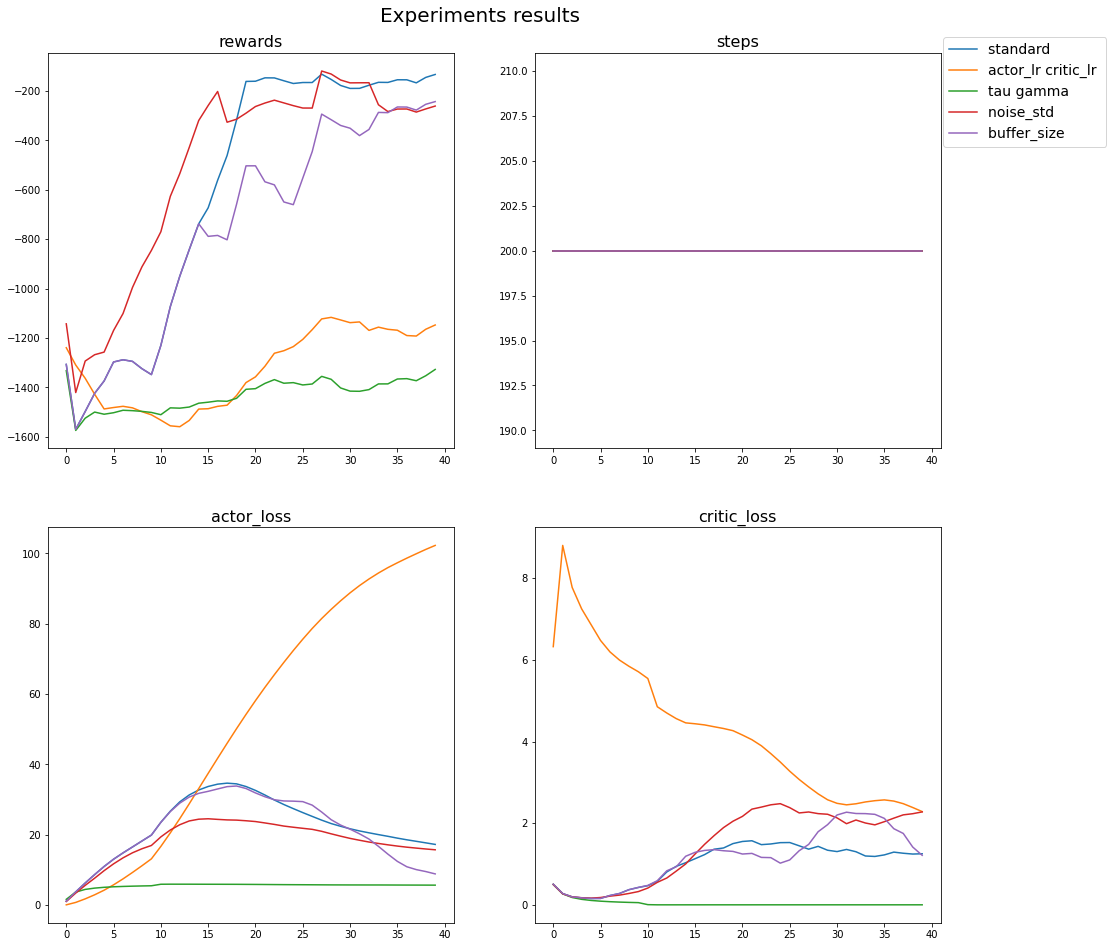

In [41]:
def moving_average(values: List[float], n=10):
    ret = np.cumsum(values, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    ret[:n - 1] /= np.arange(n - 1) + 1
    ret[n - 1:] /= n
    return ret

def plot_results(data):
    fig, ((rewards, steps), (actor_loss, critic_loss)) = plt.subplots(2, 2, figsize=(16, 16))
    fig.suptitle('Experiments results', fontsize=20, y=0.92)
    rewards.set_title('rewards', size=16)
    steps.set_title('steps', size=16)
    actor_loss.set_title('actor_loss', size=16)
    critic_loss.set_title('critic_loss', size=16)

    for (name, logs) in data:
        steps.plot(logs['episodes_lens']['episodes_lens']['y'], zorder=10, label=name)

        rewards_ma = moving_average(logs['episodes_rews']['episodes_rews']['y'])
        actor_loss_ma = moving_average(logs['actor_losses']['actor_losses']['y'])
        critic_loss_ma = moving_average(logs['critic_losses']['critic_losses']['y'])
        rewards.plot(rewards_ma, zorder=10)
        actor_loss.plot(actor_loss_ma, zorder=10)
        critic_loss.plot(critic_loss_ma, zorder=10)

    fig.legend(loc='upper right', bbox_to_anchor=(1.05, 0.9), prop={'size': 14})
    plt.show()

# Experiments for different hyperparameters
configs = [{
    'env_id': 'Pendulum-v1',
    'buffer_size': 20000,
    'batch_size': 128,
    'exploration_steps': 0,
    'episodes': 40,
    'max_episode_steps': 500,
    'actor_lr': 1e-3,
    'critic_lr': 1e-2,
    'tau': 0.99,
    'gamma': 0.99,
    'noise_mean': 0.0,
    'noise_std': 0.3,
    'noise_decay': (1, 0.05, 1e-5),
    'seed': 3275301815
} for _ in range(5)]

conf_changes = [
    [('standard', '')],
    [('actor_lr', 1e-5), ('critic_lr', 1e-4)],
    [('tau', 0.5), ('gamma', 0.5)],
    [('noise_std', 0.1)],
    [('buffer_size', 2000)]
]

plot_data = []
for conf, conf_change in zip(configs, conf_changes):
    change_name = ''
    for change in conf_change:
        conf[change[0]] = change[1]
        change_name += change[0] + ' '

    ddpg_agent = DDPGAgent(conf)
    task = ddpg_agent.train(conf)
    scalar_graphs = task.get_reported_scalars()
    plot_data.append((change_name, scalar_graphs))

plot_results(plot_data)

Unsurprisingly, change of learning rate makes convergence very slow, it would take many more episodes than used for standard configuration. Same effect has change of tau and gamma.
Smaller Gaussian noise standard deviation doesn't make much of a difference, however convergence seems a little bit faster than for standard configuration of hyperparameters.
The last one is change introducing 10x smaller buffer which eventually convergences but slower than standard.